In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.10.0
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [4]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [5]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [12]:
linear_vis(9000)

1.8888888888888888

In [8]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_fulltime.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]

# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(60040, 15)
(60040,)


In [9]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled  = scaler.fit_transform(test_x)

train_x_scaled[:,0:3] = train_x[:,0:3]
train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
valid_x_scaled[:,0:3]   = valid_x[:,0:3]
valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
test_x_scaled[:,0:3]    = test_x[:,0:3]
test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]

In [10]:
print(np.max(train_x_scaled[:,-5]), np.min(train_x_scaled[:,-5]))

0.9999855506507186 -0.9999994220246925


In [19]:
a = tf.Variable(0)
a.assign(a+1)
print(a)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>


In [84]:
# y_true [0,1] -> y_pred<1: 0.1; 1 <y_pred<4/3: 1.2;  y_pred>4/3: 10
# y_true [1,4/3] -> y_pred<1: 0.1; 1 <y_pred<4/3: 1.2;  y_pred>4/3: 10
# y_true [4/3,2] -> y_pred<1: 0.1; 1 <y_pred<4/3: 1.2;  y_pred>4/3: 10
# y_true [2,3] -> y_pred<1: 0.1; 1 <y_pred<4/3: 1.2;  y_pred>4/3: 10
def customized_mes(y_true, y_pred): # 自定义均方差
    # mse = tf.Variable(0)
    # print(y_true)
    # for index in range(y_true.shape[0]):
    #     mse.assign_add(tf.square(y_true[index]-y_pred[index]))
    # mse.assign(mse/y_true.shape[0])

    # y_true [0,1] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [0.2,0.5,1.5,3.0]
    mse_0_1   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*0.5, 
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*2.0,
                                                                      tf.square(y_pred - y_true)*3.0)))
    # y_true [1,4/3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [1.0,0.5,1.0,3.0]
    mse_1_43  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*0.5,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*1.0,
                                                                      tf.square(y_pred - y_true)*3.0)))
    # y_true [4/3,2] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [2.0,1.0,0.5,2.0]
    mse_43_2  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*2.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*0.5,
                                                                      tf.square(y_pred - y_true)*2.0)))
    # y_true [2,3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [3.0,2.0,1.0,0.5]
    mse_2_3   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*3.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*2.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*1.0,
                                                                      tf.square(y_pred - y_true)*0.5)))
    sum = tf.where(tf.less_equal(y_true, tf.constant(1.0)), mse_0_1,
          tf.where(tf.less_equal(y_true, tf.constant(4.0/3.0)), mse_1_43,
          tf.where(tf.less_equal(y_true, tf.constant(2.0)), mse_43_2, mse_2_3)
          )
        )
    return tf.reduce_mean(sum)

In [85]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(65, activation='relu',input_shape=train_x_scaled.shape[1:]),
    keras.layers.Dense(65, activation='relu',input_shape=train_x_scaled.shape[1:]),
    keras.layers.Dense(65, activation='relu',input_shape=train_x_scaled.shape[1:]),
    keras.layers.Dense(65, activation='relu',input_shape=train_x_scaled.shape[1:]),
    keras.layers.Dense(70, activation='relu',input_shape=train_x_scaled.shape[1:]),                                  
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss=customized_mes, optimizer="sgd", metrics=["mean_squared_error",])

In [86]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 65)                1040      
                                                                 
 dense_46 (Dense)            (None, 65)                4290      
                                                                 
 dense_47 (Dense)            (None, 65)                4290      
                                                                 
 dense_48 (Dense)            (None, 65)                4290      
                                                                 
 dense_49 (Dense)            (None, 70)                4620      
                                                                 
 dropout_4 (Dropout)         (None, 70)                0         
                                                                 
 dense_50 (Dense)            (None, 1)               

In [87]:
# H:/github/python/seafog/
logdir = './callbacks_reg_cus_loss'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    # keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1401/1877 [=====================>........] - ETA: 0s - loss: 0.4223 - mean_squared_error: 0.3553

In [ ]:
type(history)

In [ ]:
history.history

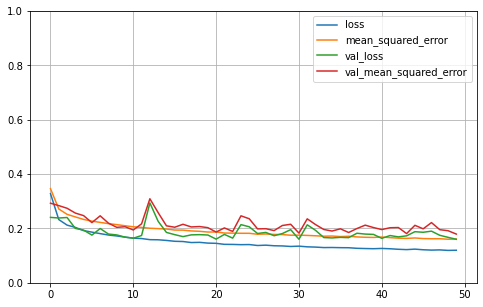

In [77]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [78]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.2564241588115692, 0.24406404793262482]

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

In [79]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.94713175],
       [1.3234223 ],
       [0.54236245],
       ...,
       [2.0002823 ],
       [2.58886   ],
       [1.9264352 ]], dtype=float32)

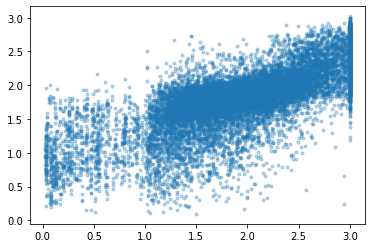

In [80]:
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()

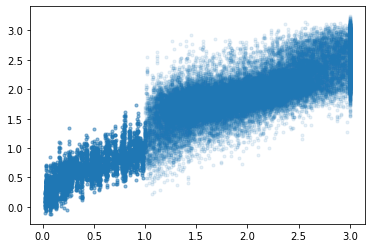

In [82]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.1)
plt.show()

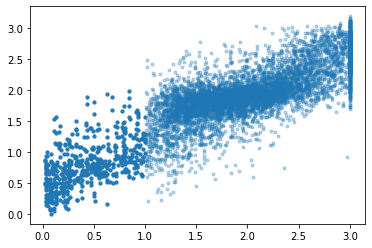

In [83]:
plt.plot(valid_y,model(valid_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 